Retrieves images from "raw_imgs" folder and stores them in "full_imgs". Retrieves spreadsheet listing VOIs and stores them in text file.

In [1]:
import helper_fxns as hf
import transforms as tr
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyelastix
import requests
import sys
import time
%matplotlib inline

In [42]:
importlib.reload(hf)
importlib.reload(tr)

<module 'transforms' from 'C:\\Users\\Clinton\\Documents\\liver-mr-processor\\transforms.py'>

In [68]:
def reg_imgs(moving, fixed, params, rescale_only=False):    
    fshape = fixed.shape
    mshape = moving.shape
    scale = [fshape[i]/mshape[i] for i in range(3)]
    moving = tr.scale3d(moving, scale)
    
    assert moving.shape == fixed.shape, ("Shapes not aligned in reg_imgs", moving.shape, fixed.shape)
    
    if not rescale_only:
        moving = np.ascontiguousarray(moving).astype('float32')
        fixed = np.ascontiguousarray(fixed).astype('float32')

        moving, _ = pyelastix.register(moving, fixed, params, verbose=0)
        _, field = pyelastix.register(fixed, moving, params, verbose=0)
    
    else:
        field = [np.zeros(fixed.shape)]*3
        
    return moving, scale, field

In [84]:
def scale_rois(x, y, z, pre_reg_scale, field=None, post_reg_scale=None):
    scale = pre_reg_scale
    x = (round(x[0]*scale[0]), round(x[1]*scale[0]))
    y = (round(y[0]*scale[1]), round(y[1]*scale[1]))
    z = (round(z[0]*scale[2]), round(z[1]*scale[2]))
    
    if field is not None:
        xroi_distortions = field[0][x[0]:x[1]+1, y[0]:y[1]+1, z[0]:z[1]+1]
        yroi_distortions = field[1][x[0]:x[1]+1, y[0]:y[1]+1, z[0]:z[1]+1]
        zroi_distortions = field[2][x[0]:x[1]+1, y[0]:y[1]+1, z[0]:z[1]+1]

        x = (x[0] + int(np.amin(xroi_distortions[0,:,:])), x[1] + int(np.amax(xroi_distortions[-1,:,:])))
        y = (y[0] + int(np.amin(yroi_distortions[:,0,:])), y[1] + int(np.amax(yroi_distortions[:,-1,:])))
        z = (z[0] + int(np.amin(zroi_distortions[:,:,0])), z[1] + int(np.amax(zroi_distortions[:,:,-1])))
    
        scale = post_reg_scale
        x = (round(x[0]*scale[0]), round(x[1]*scale[0]))
        y = (round(y[0]*scale[1]), round(y[1]*scale[1]))
        z = (round(z[0]*scale[2]), round(z[1]*scale[2]))
    
    return x, y, z

In [4]:
#mrn = '13064153'
#roi = (148,157,132,144,38,44)
#x=(roi[0], roi[1])
#y=(roi[2], roi[3])
#z=(roi[4], roi[5])

In [70]:
def add_roi(mrn, x, y, z, cls):
    rois.append([str(mrn) + ".npy", x[0], x[1], y[0], y[1], z[0], z[1], cls])

def apply_mask(img, mask_file):
    with open(mask_file, 'rb') as f:
        mask = f.read()
        mask = np.fromstring(mask, dtype='uint8')
        mask = np.array(mask).reshape((img.shape[2], img.shape[1], img.shape[0]))
        mask = np.transpose(mask, (2,1,0))
        
    img[:,:,:,0][mask == 0] = 0

    return img

In [71]:
def preprocess_df(df):
    """Select only rows for this run. Collect MRNs and ROI coordinates."""
    df = df[(df['Run'] == 1) & (df['Image type'] == 'AP-T1')].dropna(subset=["x1"])
    return df.drop(set(df.columns).difference(['Patient E Number', 
          'x1', 'x2', 'y1', 'y2', 'z1', 'z2', 'Image type']), axis=1)

In [72]:
def load_imgs(df, base_dir, cls):
    """Create ROI file, apply whole liver mask, validate/scale dimensions"""

    def validate_dims(imgs, mrns):
        """Validate that all series of the same MRN have the same dimensions.
        Images formatted as list of dicts. Each dict is a different image channel, indexed by MRN."""
        for mrn in mrns:
            for x in range(1,len(imgs)):
                assert imgs[0][mrn].shape == imgs[x][mrn].shape, "img %s has wrong shape" % mrn
                
    pass

In [73]:
def rescale(img, target_dims, cur_dims):
    vox_scale = [float(cur_dims[i]/target_dims[i]) for i in range(3)]
    img = tr.scale3d(img, vox_scale)
    
    return img, vox_scale

In [112]:
#pre = {}
art = {}
#ven = {}
#equ = {}
t2 = {}
field = {}
rois = []

base_dir = r'raw_imgs\simple_cysts'
cls='cyst'
df = pd.read_excel(r'raw_imgs\Prototype1CL.xlsx', sheetname="Hepatic Cyst")
df = preprocess_df(df)
#load_imgs(df, base_dir=r'raw_imgs\simple_cysts', cls='cyst')

params = pyelastix.get_default_params(type="RIGID")

img_dir = "full_imgs"
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

In [119]:
print("Loading DCMs...")
mrns = list(set(df['Patient E Number'].dropna().astype(str).tolist()))
s = time.time()
target_dims = [1.5,1.5,4]
rescale_time = 0
load_time = 0
reg_time = 0

for cnt, mrn in enumerate(["13010227"]):
    subdir = base_dir+"\\"+mrn
    
    t_load = time.time()
    art[mrn], cur_dims = hf.dcm_load(subdir+r"\T1_AP")
    #pre[mrn] = hf.dcm_load(subdir+r"\T1_BL")
    #ven[mrn] = hf.dcm_load(subdir+r"\T1_VP")
    #equ[mrn] = hf.dcm_load(subdir+r"\T1_EQ")
    t2[mrn], _ = hf.dcm_load(subdir+r"\T2")
    load_time += time.time() - t_load
    
    df_subset = df.loc[df['Patient E Number'].astype(str) == mrn]

    t_reg = time.time()
    t2[mrn], reg_scale, field[mrn] = reg_imgs(moving=t2[mrn], fixed=art[mrn], params=params, rescale_only=True)
    t2[mrn] = t2[mrn] * 255/np.amax(t2[mrn])
    reg_time += time.time() - t_reg

    img = np.transpose(np.stack((art[mrn], t2[mrn])), (1,2,3,0))

    #mask_file = base_dir + "\\" + mrn + r'\00_segs\liver.ids'
    #img = apply_mask(img, mask_file)

    #nonzeros = np.nonzero(img)
    #minx, maxx = min(nonzeros[0]), max(nonzeros[0])
    #miny, maxy = min(nonzeros[1]), max(nonzeros[1])
    #minz, maxz = min(nonzeros[2]), max(nonzeros[2])
    #img = img[minx:maxx, miny:maxy, minz:maxz, :]

    np.save(img_dir + "\\" + mrn, img)
    
    t_scale = time.time()
    img, vox_scale = rescale(img, target_dims, cur_dims)
    rescale_time += time.time() - t_scale
    
    print(cur_dims, art[mrn].shape)
    print(target_dims, img.shape)
    
    for _, row in df_subset.iterrows():
        x = (int(row['x1']), int(row['x2']))
        y = (int(row['y1']), int(row['y2']))
        z = (int(row['z1']), int(row['z2']))
        
        t_scale = time.time()
        #if cls == "cyst":
        #    x,y,z = scale_rois(x, y, z, reg_scale, field[mrn], vox_scale)
        #else:
        x,y,z = scale_rois(x, y, z, vox_scale)
        rescale_time += time.time() - t_scale

        y = (img.shape[1]-y[1], img.shape[1]-y[0]) # flip y
        z = (img.shape[2]-z[1], img.shape[2]-z[0]) # flip z

        #x = (x[0] - minx, x[1] - minx)
        #y = (y[0] - miny, y[1] - miny)
        #z = (z[0] - minz, z[1] - minz)

        add_roi(mrn, x,y,z, cls)

    print(mrn, "%d out of %d MRNs loaded" % (cnt+1, len(mrns)))
#validate_dims([t2, art], mrns)
print("Overall time: %s" % str(time.time() - s))
print("Time to load dcms: %s" % str(load_time))
print("Time rescaling: %s" % str(rescale_time))
print("Time registering: %s" % str(reg_time))

#s = time.time()
#print("Time to mask, crop, load rois, and save .npy files: %s" % str(time.time() - s))

Loading DCMs...
[ 1.25  1.25  3.  ] (320, 260, 88)
[1.5, 1.5, 4] (267, 217, 66, 2)
13010227 1 out of 8 MRNs loaded
Overall time: 11.173704624176025
Time to load dcms: 10.022962093353271
Time rescaling: 0.35659050941467285
Time registering: 0.11527729034423828


In [113]:
base_dir = r'raw_imgs\OPTN5A'
cls='hcc'
df = pd.read_excel(r'raw_imgs\Prototype1CL.xlsx', sheetname="OPTN 5A")
df = preprocess_df(df)
#load_imgs(df, base_dir = r'raw_imgs\OPTN5A', cls='hcc')

Loading DCMs...
12905568 1 out of 8 MRNs loaded
13010227 2 out of 8 MRNs loaded
E101047106 3 out of 8 MRNs loaded
12972894 4 out of 8 MRNs loaded
E104657225 5 out of 8 MRNs loaded
E103599300 6 out of 8 MRNs loaded
E105152534 7 out of 8 MRNs loaded
13064153 8 out of 8 MRNs loaded
Overall time: 82.75778675079346
Time to load dcms: 73.75834655761719
Time rescaling: 2.7530956268310547
Time registering: 0.7827937602996826


In [45]:
# rois = np.unique(rois, axis=0)
#with open('train_list.txt', 'w') as f:
#    for roi in rois:
#        f.write(",".join([str(x) for x in roi]) + "\n")

In [120]:
voi_df = pd.DataFrame(rois, columns = ["Filename", "x1", "x2", "y1", "y2", "z1", "z2", "cls"]).dropna()
voi_df = voi_df.astype({"x1": int, "x2": int, "y1": int, "y2": int, "z1": int, "z2": int})
voi_df['dx'] = voi_df.apply(lambda row: row['x2'] - row['x1'], axis=1)
voi_df['dy'] = voi_df.apply(lambda row: row['y2'] - row['y1'], axis=1)
voi_df['dz'] = voi_df.apply(lambda row: row['z2'] - row['z1'], axis=1)

In [27]:
voi_df.to_csv('vois.csv', index=False)

In [89]:
def plot_section(img, df, pad=30):
    plt.subplot(121)
    plt.imshow(np.transpose(img[df['x1']-pad:df['x2']+pad,
                                df['y2']+pad:df['y1']-pad:-1,
                                (df['z1']+df['z2'])//2, 0], (1,0)), cmap='gray')
    plt.subplot(122)
    plt.imshow(np.transpose(img[df['x1']-pad:df['x2']+pad,
                                df['y2']+pad:df['y1']-pad:-1,
                                (df['z1']+df['z2'])//2, 1], (1,0)), cmap='gray')

def plot_section_xyz(img, x,y,z, pad=30):
    plt.subplot(121)
    plt.imshow(np.transpose(img[x[0]-pad:x[1]+pad, y[1]+pad:y[0]-pad:-1, (z[0]+z[1])//2,0], (1,0)), cmap='gray')
    plt.subplot(122)
    plt.imshow(np.transpose(img[x[0]-pad:x[1]+pad, y[1]+pad:y[0]-pad:-1, (z[0]+z[1])//2,1], (1,0)), cmap='gray')
    

def plot_section_mrn(mrn,x,y,z, pad=30):
    plt.subplot(211)
    plt.imshow(np.transpose(art[mrn][x[0]-pad:x[1]+pad, y[1]+pad:y[0]-pad:-1, (z[0]+z[1])//2], (1,0)), cmap='gray')
    plt.subplot(212)
    plt.imshow(np.transpose(t2[mrn][x[0]-pad:x[1]+pad, y[1]+pad:y[0]-pad:-1, (z[0]+z[1])//2], (1,0)), cmap='gray')

In [121]:
img_fn = "13010227.npy"
img = np.load("full_imgs\\"+img_fn)

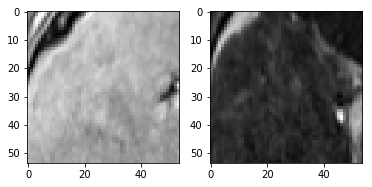

In [122]:
plot_section(img, voi_df[voi_df["Filename"] == img_fn].iloc[0], pad=20)

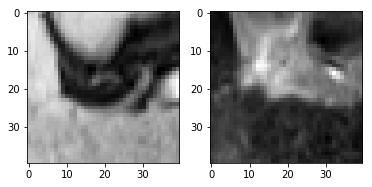

In [94]:
plot_section_xyz(img, (89,109), (138,158), (41,50), pad=10)

In [93]:
voi_df[voi_df["Filename"] == img_fn]

,Filename,x1,x2,y1,y2,z1,z2,cls,dx,dy,dz
0,13010227.npy,62,76,96,110,28,34,hcc,14,14,6
